In [14]:
# Mount local drive
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
import time
from structlog import get_logger

# Configure logger
logger = get_logger()

# Remove the project folder if it exists and clone the repository
project_folder = '/content/comp642-project'
if os.path.exists(project_folder):
    !rm -r {project_folder}
    logger.info("Project 'comp642-project' folder will be updated")
else:
    logger.info("Project 'comp642-project' does not exist")

# Clone the repository
!git clone https://github.com/fdraverta/comp642-project.git

# Install necessary packages
!pip install structlog

# Add the module path to sys.path and attempt to import featurizer
module_path = '/content/comp642-project/FRaverta-Notebooks'
featurizer_file = os.path.join(module_path, 'featurizer.py')
if os.path.exists(featurizer_file):
    logger.info(f"Adding module path: {module_path}")
    sys.path.append(module_path)
    from featurizer import *  # Import if the module exists
else:
    raise FileNotFoundError("The module 'featurizer.py' does not exist in the specified directory.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2024-04-30 02:59:57 [info     ] Project 'comp642-project' folder will be updated
Cloning into 'comp642-project'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 102 (delta 49), reused 51 (delta 17), pack-reused 0
Receiving objects: 100% (102/102), 2.42 MiB | 22.52 MiB/s, done.
Resolving deltas: 100% (49/49), done.
Error downloading object: trading_the_close_data.zip (dc21aee): Smudge error: Error downloading trading_the_close_data.zip (dc21aee5a066619738399ef9faf1db53370568a6df65fd976a1ed35baf89d184): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /content/comp642-project/.git/lfs/logs/20240430T025958.09314028.log
Use `git lfs logs last` to v

In [15]:
data = TradingAtTheCloseDS("/content/drive/MyDrive/trading_the_close_data.zip")
train_data, test_data = data.get_train_test_data()
train_mae, test_mae = data.compute_baseline_model()

2024-04-30 03:00:04 [info     ] Using ZIP file with the data set from the provided path path=/content/drive/MyDrive/trading_the_close_data.zip
2024-04-30 03:00:04 [info     ] Opening ZIP file...
2024-04-30 03:00:04 [info     ] Reading CSV file...            fname=train.csv
2024-04-30 03:00:21 [info     ] Data set loaded successfully.
2024-04-30 03:00:21 [info     ] Train and test data sets created. test_data=(616000, 17) test_proportion=0.13327621495549527 train_data=(4621980, 17)
2024-04-30 03:00:22 [info     ] Train and test data sets created. test_data=(616000, 17) test_proportion=0.13327621495549527 train_data=(4621980, 17)
2024-04-30 03:00:22 [info     ] Baseline model computed.       test_mae=5.8499749700259205 train_mae=6.481303604250604


In [16]:
#drop rows with nan in wap column
#train_data = train_data.dropna(subset=['wap'])
#test_data = test_data.dropna(subset=['wap'])

x_train = train_data[data.categorical_features + data.numerical_features + ["date_id"] + data.y_column]
x_test = test_data[data.categorical_features + data.numerical_features + ["date_id"] + data.y_column]

#NN whole DS

In [17]:
x_train = x_train.drop(columns=['far_price', 'near_price'])
x_test = x_test.drop(columns=['far_price', 'near_price'])

# count nan
print(x_train.isna().sum())
print(x_test.isna().sum())


stock_id                     0
imbalance_buy_sell_flag      0
seconds_in_bucket            0
imbalance_size             165
reference_price            165
matched_size               165
bid_price                  165
bid_size                     0
ask_price                  165
ask_size                     0
wap                        165
date_id                      0
target                      87
dtype: int64
stock_id                    0
imbalance_buy_sell_flag     0
seconds_in_bucket           0
imbalance_size             55
reference_price            55
matched_size               55
bid_price                  55
bid_size                    0
ask_price                  55
ask_size                    0
wap                        55
date_id                     0
target                      1
dtype: int64


# Sort Data

In [18]:
# sort the data by stock_id, date_id, seconds_in_bucket
x_train_sorted = x_train.sort_values(by=['stock_id', 'date_id', 'seconds_in_bucket'])

# sort the data by stock_id, date_id, seconds_in_bucket
x_test_sorted = x_test.sort_values(by=['date_id', 'seconds_in_bucket', 'stock_id'])

# Index coeficients

## Add index coef

In [19]:


coef_train = [0.004,0.00099987, 0.00200041, 0.00599891, 0.00400068, 0.00399949,
0.00200014, 0.0059992 , 0.00600029, 0.00200012, 0.00200072, 0.00800012,
0.00600039, 0.00200007, 0.0080014 , 0.00600051, 0.00199993, 0.0059999,
0.00400013, 0.00199974, 0.00399933, 0.00099993, 0.00599955, 0.00399971,
0.00199876, 0.00200008, 0.00400097, 0.0020008 , 0.00400021, 0.00400005,
0.00100001, 0.00100016, 0.00199924, 0.00199993, 0.00599995, 0.00399917,
0.00400017, 0.00399906, 0.00599977, 0.00200015, 0.0020007 , 0.03999955,
0.0020001 , 0.00199981, 0.00399968, 0.03999983, 0.00200033, 0.00099959,
0.00600002, 0.00399944, 0.00399979, 0.00600017, 0.00099921, 0.00399993,
0.00399936, 0.0019985 , 0.00599995, 0.00400028, 0.00599981, 0.00400045,
0.00600029, 0.00399988, 0.00200012, 0.00100003, 0.00200041, 0.00400043,
0.00200011, 0.00799989, 0.00400056, 0.00400011, 0.00199956, 0.00399921,
0.00599994, 0.00199992, 0.00399979, 0.00400047, 0.00200035, 0.00399996,
0.00400003, 0.00399989, 0.00100029, 0.00199997, 0.00200019, 0.00799969,
0.02000066, 0.00400029, 0.00600019, 0.00200024, 0.02      , 0.00199965,
0.00199968, 0.00599962, 0.00399987, 0.00199997, 0.00099953, 0.02000033,
0.00600029, 0.00099946, 0.00200062, 0.00399946, 0.00100021, 0.00199986,
0.00600047, 0.00600071, 0.00399889, 0.00600028, 0.0010003 , 0.00199986,
0.00400008, 0.00600071, 0.00600016, 0.00100013, 0.04000011, 0.00599947,
0.00200012, 0.00400061, 0.00199956, 0.00199961, 0.00599985, 0.00200055,
0.00200083, 0.00399993, 0.00599961, 0.00600028, 0.00200005, 0.00199999,
0.0080003 , 0.00600021, 0.00400044, 0.00199994, 0.00599988, 0.00200002,
0.00399908, 0.00600099, 0.00200021, 0.00399981, 0.00100042, 0.00399994,
0.00199993, 0.0039995 , 0.00800063, 0.00600055, 0.00799953, 0.00200005,
0.00400064, 0.00199988, 0.00099981, 0.00399912, 0.00399992, 0.00399974,
0.00599995, 0.00800022, 0.00400055, 0.00099968, 0.00099956, 0.00200017,
0.00599973, 0.00400059, 0.00100004, 0.00199961, 0.00599971, 0.00400006,
0.00599987, 0.00800007, 0.00200054, 0.00200102, 0.00400114, 0.00199923,
0.0399987 , 0.00199969, 0.00199982, 0.00399976, 0.00199995, 0.00200001,
0.00599982, 0.02000055, 0.0039996 , 0.00200022, 0.00600002, 0.01999984,
0.00100015, 0.00200021, 0.0059996 , 0.00400055, 0.00599988, 0.00400022,
0.00399931, 0.0040002 , 0.0039998 , 0.002     , 0.00399975, 0.04000041,
0.00200037, 0.00799998, 0.00199977, 0.00400093, 0.00099996, 0.00400022,
0.00599947, 0.00400014]

coef_validation = coef_train
x_train_sorted["weights"] = x_train_sorted["stock_id"].apply(lambda x: coef_train[x])
x_test_sorted["weights"] = x_test_sorted["stock_id"].apply(lambda x: coef_train[x])


## Compute index WAP

In [20]:
from tqdm import tqdm


def compute_index(df):
    index_values = {'date_id': [], "seconds_in_bucket":[], 'index_wap': []}
    for (date, seconds_in_bucket), records  in tqdm(df.groupby(['date_id', 'seconds_in_bucket'])):
        index_values['date_id'].append(date)
        index_values['seconds_in_bucket'].append(seconds_in_bucket)
        index_values['index_wap'].append(sum(records['wap'].fillna(1)* records['weights']))

    return pd.DataFrame(index_values)


train_index = compute_index(x_train_sorted)
x_train_sorted = x_train_sorted.merge(train_index, on=['date_id', 'seconds_in_bucket'], how='left')
test_index = compute_index(x_test_sorted)
x_test_sorted = x_test_sorted.merge(test_index, on=['date_id', 'seconds_in_bucket'], how='left')

100%|██████████| 3080/3080 [00:00<00:00, 3085.06it/s]


### Compute target and print error

stock_id                        0
imbalance_buy_sell_flag         0
seconds_in_bucket               0
imbalance_size                165
reference_price               165
matched_size                  165
bid_price                     165
bid_size                        0
ask_price                     165
ask_size                        0
wap                           165
date_id                         0
target                         87
weights                         0
index_wap                       0
wap_t+60                   504363
index_wap_t+60             504216
predicted_target           504363
dtype: int64
train
stock_id                   0
imbalance_buy_sell_flag    0
seconds_in_bucket          0
imbalance_size             0
reference_price            0
matched_size               0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
date_id                    0
target               

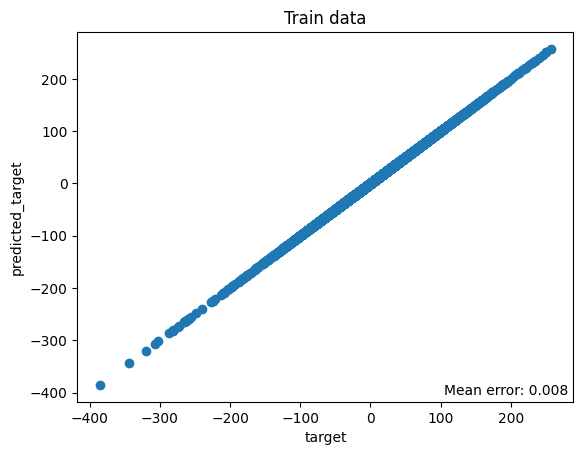

stock_id                       0
imbalance_buy_sell_flag        0
seconds_in_bucket              0
imbalance_size                55
reference_price               55
matched_size                  55
bid_price                     55
bid_size                       0
ask_price                     55
ask_size                       0
wap                           55
date_id                        0
target                         1
weights                        0
index_wap                      0
wap_t+60                   67249
index_wap_t+60             67200
predicted_target           67249
dtype: int64
test
stock_id                   0
imbalance_buy_sell_flag    0
seconds_in_bucket          0
imbalance_size             0
reference_price            0
matched_size               0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
date_id                    0
target                     0
weights    

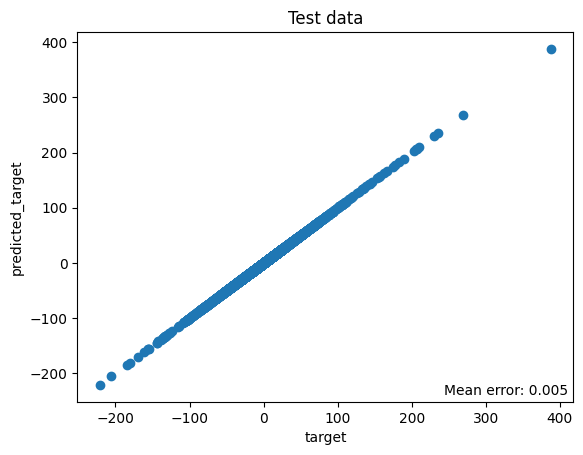

,stock_id,imbalance_buy_sell_flag,seconds_in_bucket,imbalance_size,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,date_id,target,weights,index_wap,wap_t+60,index_wap_t+60,predicted_target,error
0,0,-1,0,7218754.93,1.000062,22642235.17,0.999873,10813.75,1.000062,5276.00,1.000000,425,1.809597,0.004,1.000000,1.000141,0.999960,1.810778,0.001181
200,0,-1,10,6166574.88,1.000062,23694415.22,1.000062,28437.64,1.000252,10554.00,1.000200,425,-1.549721,0.004,0.999861,1.000120,0.999936,-1.550200,0.000479
400,0,-1,20,6179553.04,1.000252,23694415.22,1.000252,17889.03,1.000631,19321.14,1.000434,425,-1.710057,0.004,0.999995,1.000082,0.999814,-1.713648,0.003591
600,0,-1,30,6513133.79,1.000062,23694415.22,1.000062,29440.08,1.000252,17044.71,1.000182,425,-1.320243,0.004,0.999933,0.999920,0.999803,-1.318617,0.001625
800,0,-1,40,6492927.96,0.999873,23694415.22,0.999873,42411.00,1.000252,69867.48,1.000016,425,-1.339912,0.004,0.999764,0.999977,0.999859,-1.339204,0.000709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613999,199,0,440,0.00,1.001812,23777108.28,1.001812,176332.95,1.002129,113363.52,1.002005,480,8.859634,0.004,0.998912,1.002835,0.998855,8.858866,0.000768
614199,199,0,450,0.00,1.001812,23777108.28,1.001812,218925.45,1.002129,194251.80,1.001980,480,9.020567,0.004,0.998803,1.002974,0.998894,9.013632,0.006935
614399,199,-1,460,135671.59,1.001812,23784351.66,1.001812,233186.05,1.002129,226222.08,1.001973,480,0.849962,0.004,0.998888,1.001982,0.998812,0.846529,0.003433
614599,199,-1,470,796236.05,1.001812,23788288.28,1.001812,245774.50,1.002129,394815.60,1.001934,480,0.760555,0.004,0.998825,1.001993,0.998808,0.756874,0.003682


In [21]:
import matplotlib.pyplot as plt

for label, df in zip(['train', 'test'], [x_train_sorted, x_test_sorted]):

    aux_df = df.sort_values(by=["stock_id", "date_id", "seconds_in_bucket"])
    aux_df["wap_t+60"] = aux_df.groupby(["stock_id", "date_id"])["wap"].shift(-6)
    aux_df["index_wap_t+60"] = aux_df.groupby(["stock_id", "date_id"])["index_wap"].shift(-6)
    aux_df["predicted_target"] = ((aux_df["wap_t+60"] / aux_df["wap"]) - (aux_df["index_wap_t+60"] / aux_df["index_wap"])) * 10000

    print(aux_df.isna().sum())
    # Measure computation error
    aux_df.dropna(subset=["wap", "wap_t+60", "target"], inplace=True)
    # count nan
    print(label)
    print(aux_df.isna().sum())
    aux_df["error"] = abs(aux_df["predicted_target"] - aux_df["target"])
    aux_df["error"].mean()
    logger.info(f"Mean error {label} data", error=aux_df["error"].mean())

    # plot scatter plot target vs predicted target
    plt.scatter(aux_df['target'], aux_df['predicted_target'])
    plt.xlabel('target')
    plt.ylabel('predicted_target')
    plt.title(f'{label.title()} data')
    # show loss bottom right
    plt.text(0.99, 0.01, f'Mean error: {aux_df["error"].mean():.3f}', verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes)
    plt.show()

aux_df
#del aux_df



In [22]:
x_train_sorted.dropna(subset=["wap", "target"], inplace=True)
x_test_sorted.dropna(subset=["wap", "target"], inplace=True)




In [23]:
x_train_sorted

,stock_id,imbalance_buy_sell_flag,seconds_in_bucket,imbalance_size,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,date_id,target,weights,index_wap
0,0,1,0,3180602.69,0.999812,13380276.64,0.999812,60651.50,1.000026,8493.03,1.000000,0,-3.029704,0.004,0.961000
1,0,1,10,1299772.70,1.000026,15261106.63,0.999812,13996.50,1.000026,23519.16,0.999892,0,0.389814,0.004,0.961342
2,0,1,20,1299772.70,0.999919,15261106.63,0.999812,4665.50,0.999919,12131.60,0.999842,0,4.220009,0.004,0.961504
3,0,1,30,1299772.70,1.000133,15261106.63,1.000026,55998.00,1.000133,46203.30,1.000085,0,5.450249,0.004,0.961526
4,0,1,40,1218204.43,1.000455,15342674.90,1.000241,14655.95,1.000455,26610.45,1.000317,0,3.169775,0.004,0.961610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4621975,199,0,500,0.00,0.999846,13423224.24,0.999846,135422.59,1.000188,199884.64,0.999984,424,-2.070069,0.004,0.999403
4621976,199,0,510,0.00,0.999504,13420300.79,0.999504,49878.54,0.999846,187978.13,0.999576,424,2.110004,0.004,0.999302
4621977,199,0,520,0.00,0.999504,13420300.79,0.999504,63787.26,0.999846,190550.37,0.999590,424,4.700422,0.004,0.999350
4621978,199,0,530,0.00,0.999504,13420300.79,0.999504,71296.80,0.999846,199699.36,0.999594,424,4.329681,0.004,0.999326


In [24]:
def get_record_at_t_plus_60(df, stock_id, date_id, seconds_in_bucket):
  return df[(df["stock_id"] == stock_id) & (df["date_id"] == date_id) & (df["seconds_in_bucket"] == seconds_in_bucket)]


x_train_sorted['next_60_seconds_in_bucket'] = x_train_sorted['seconds_in_bucket'] + 60


# Merge to find the corresponding records
x_train_sorted2 = pd.merge(
    x_train_sorted,
    x_train_sorted[['stock_id', 'date_id', 'seconds_in_bucket', 'wap']],
    left_on=['stock_id', 'date_id', 'next_60_seconds_in_bucket'],
    right_on=['stock_id', 'date_id', 'seconds_in_bucket'],
    how='inner'  # Change to 'left' or 'outer' if needed
)

x_train_sorted2 = x_train_sorted2.drop(columns=['next_60_seconds_in_bucket'])
x_train_sorted2 = x_train_sorted2.rename(columns={'wap_y': 'wap_t+60', 'wap_x': 'wap', 'seconds_in_bucket_x': 'seconds_in_bucket'})
x_train_sorted2


x_test_sorted['next_60_seconds_in_bucket'] = x_test_sorted['seconds_in_bucket'] + 60


# Merge to find the corresponding records
x_test_sorted2 = pd.merge(
    x_test_sorted,
    x_test_sorted[['stock_id', 'date_id', 'seconds_in_bucket', 'wap']],
    left_on=['stock_id', 'date_id', 'next_60_seconds_in_bucket'],
    right_on=['stock_id', 'date_id', 'seconds_in_bucket'],
    how='inner'  # Change to 'left' or 'outer' if needed
)

x_test_sorted2 = x_test_sorted2.drop(columns=['next_60_seconds_in_bucket'])
x_test_sorted2 = x_test_sorted2.rename(columns={'wap_y': 'wap_t+60', 'wap_x': 'wap', 'seconds_in_bucket_x': 'seconds_in_bucket'})
x_test_sorted2

,stock_id,imbalance_buy_sell_flag,seconds_in_bucket,imbalance_size,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,date_id,target,weights,index_wap,seconds_in_bucket_y,wap_t+60
0,0,-1,0,7218754.93,1.000062,2.264224e+07,0.999873,10813.75,1.000062,5276.00,1.000000,425,1.809597,0.004000,1.000000,60,1.000141
1,1,1,0,238616.53,0.999666,1.585546e+06,0.999223,18022.00,1.000054,1262.59,1.000000,425,-3.420114,0.001000,1.000000,60,0.999618
2,2,1,0,4673615.43,0.999974,2.088183e+06,0.999974,895.52,1.000644,22403.00,1.000000,425,-0.410080,0.002000,1.000000,60,0.999919
3,3,-1,0,3022158.48,0.999961,1.100225e+08,0.999961,31167.18,1.000063,50186.24,1.000000,425,1.610518,0.005999,1.000000,60,1.000121
4,4,-1,0,51388.69,0.999897,2.034596e+07,0.999897,16852.44,1.000200,32888.73,1.000000,425,9.109974,0.004001,1.000000,60,1.000870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548746,195,-1,480,3202296.36,1.000551,2.773320e+07,1.000551,19822.11,1.000667,60932.20,1.000579,480,-1.389980,0.004001,0.998868,540,1.000328
548747,196,-1,480,374092.11,1.000643,9.163117e+06,1.000643,108859.24,1.000900,69567.91,1.000800,480,1.319647,0.001000,0.998868,540,1.000819
548748,197,-1,480,1109455.00,0.996164,1.255927e+07,0.996164,42524.00,0.996538,187814.10,0.996233,480,-3.259778,0.004000,0.998868,540,0.995797
548749,198,0,480,0.00,0.999210,9.427924e+07,0.999210,366528.00,0.999451,425768.07,0.999322,480,-2.020001,0.005999,0.998868,540,0.999008


# Train a model to predict, for each stock wap at t+60

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import pickle

# Numerical pipeline with feature addition
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

# Categorical pipeline
categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder())
])

# Combine pipelines
preprocessing_pipeline = ColumnTransformer([
    ('num', numerical_pipeline, [f for f in data.numerical_features if f not in ["far_price", "near_price"]]),
    ('cat', categorical_pipeline, [ 'imbalance_buy_sell_flag']),
    #('stock_id', OneHotEncoder(categories=[list(range(200))]), ['stock_id'])
])

x_train, y_train, target_train = x_train_sorted2.drop(columns=['wap_t+60', "target", "index_wap"]), x_train_sorted2[['wap_t+60']], x_train_sorted2["target"]
x_test, y_test, target_test = x_test_sorted2.drop(columns=['wap_t+60', "target", "index_wap"]), x_test_sorted2[['wap_t+60']], x_test_sorted2["target"]



# Applying the pipeline
x_train_transformed = x_train.drop(columns=['stock_id'])
x_train_transformed = preprocessing_pipeline.fit_transform(x_train_transformed)
x_test_transformed = x_test.drop(columns=['stock_id'])
x_test_transformed = preprocessing_pipeline.transform(x_test_transformed)

# initiate a serie with all values nan
x_train["wap_t+60_pred"] = np.nan
for i in range(200):
  x_stock_i = x_train_transformed[x_train[x_train["stock_id"] == i].index, :]
  y_stock_i = y_train.loc[x_train[x_train["stock_id"] == i].index]

  x_test_stock_i = x_test_transformed[x_test[x_test["stock_id"] == i].reset_index(drop=True).index, :]
  y_test_stock_i = y_test.loc[x_test[x_test["stock_id"] == i].index]

  # FIT XGBoost model
  xgb_model = XGBRegressor(
      n_estimators=100,
      random_state=42,
      verbose=1,
      n_jobs=-1,
      max_depth=25,
      reg_alpha=0.1,  # L1 regularization
      reg_lambda=1.0,  # L2 regularization
  )
  xgb_model.fit(x_stock_i, y_stock_i.values.reshape(-1))

  # Save the model
  #with open(f'xgb_model_{i}.pkl', 'wb') as f:
  #    pickle.dump(xgb_model, f)

  # calculate train mae
  y_pred_train = xgb_model.predict(x_stock_i)
  subset_index = x_train[x_train["stock_id"] == i].index

  if len(y_pred_train) == len(subset_index):
    print(f"Model trained for stock {i}")
    print(f"y_pred_train shape: {y_pred_train.shape}")
    print(f"subset_index shape: {subset_index.shape}")
    x_train.loc[subset_index, "wap_t+60_pred"] = y_pred_train
  else:
    assert False, f"y_pred_train shape: {y_pred_train.shape}, subset_index shape: {subset_index.shape}"

  #logger.info("shapes",  y_pred_train=y_pred_train.reshape(-1).shape,  y_stock_i=y_stock_i.T.values.reshape(-1).shape)
  train_mae = mean_absolute_error(y_stock_i.T.values.reshape(-1), y_pred_train.reshape(-1))

  # calculate test mae
  y_pred_test = xgb_model.predict(x_test_stock_i)
  test_mae = mean_absolute_error(y_test_stock_i.T.values.reshape(-1), y_pred_test.reshape(-1))

  x_test.loc[x_test[x_test["stock_id"] == i].index, "wap_t+60_pred"] = y_pred_test

  logger.info(f"Model trained for stock {i}", mae=train_mae, test_mae=test_mae)






/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 0
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:10 [info     ] Model trained for stock 0      mae=0.0005430615294631645 test_mae=0.0011358084010396677


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 1
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:11 [info     ] Model trained for stock 1      mae=0.0009095186433809975 test_mae=0.0020898913516525634
Model trained for stock 2
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:11 [info     ] Model trained for stock 2      mae=0.0008225704188021031 test_mae=0.001700926181941965


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 3
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:12 [info     ] Model trained for stock 3      mae=0.0005035002593277914 test_mae=0.0010604292866203614
Model trained for stock 4
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:12 [info     ] Model trained for stock 4      mae=0.0005887944995998279 test_mae=0.0010746885834671662


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 5
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:12 [info     ] Model trained for stock 5      mae=0.000897501575385708 test_mae=0.0017982411340610627
Model trained for stock 6
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:12 [info     ] Model trained for stock 6      mae=0.000743626049668769 test_mae=0.0015668701440015957


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 7
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:12 [info     ] Model trained for stock 7      mae=0.0008382380492176732 test_mae=0.0016411968885830482
Model trained for stock 8
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:12 [info     ] Model trained for stock 8      mae=0.0007324749798715866 test_mae=0.0013042527657903674
Model trained for stock 9
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:12 [info     ] Model trained for stock 9      mae=0.000597288584436277 test_mae=0.0014008039690579335


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 10
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:12 [info     ] Model trained for stock 10     mae=0.0005383688245008083 test_mae=0.0012890785045679388


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 11
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:13 [info     ] Model trained for stock 11     mae=0.001226115726427351 test_mae=0.0026723652723412475
Model trained for stock 12
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:13 [info     ] Model trained for stock 12     mae=0.0004958280352209857 test_mae=0.0010885796850457479


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 13
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:13 [info     ] Model trained for stock 13     mae=0.0007923589342160819 test_mae=0.0017539303567207943
Model trained for stock 14
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:13 [info     ] Model trained for stock 14     mae=0.0006725106436148063 test_mae=0.0016185935433599057


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 15
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:13 [info     ] Model trained for stock 15     mae=0.0007744283982013831 test_mae=0.0015659630767374609
Model trained for stock 16
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:13 [info     ] Model trained for stock 16     mae=0.000756118679300151 test_mae=0.0015509328298457512


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 17
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:13 [info     ] Model trained for stock 17     mae=0.0008387350014066292 test_mae=0.0014995333290127883
Model trained for stock 18
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:14 [info     ] Model trained for stock 18     mae=0.0009764578561143087 test_mae=0.002050654886640543


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 19
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:14 [info     ] Model trained for stock 19     mae=0.0008810427080494673 test_mae=0.001723031403298456
Model trained for stock 20
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:14 [info     ] Model trained for stock 20     mae=0.0006522167387296712 test_mae=0.001275778424657817
Model trained for stock 21
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:14 [info     ] Model trained for stock 21     mae=0.0005378470289972678 test_mae=0.0012416850999687585


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 22
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:14 [info     ] Model trained for stock 22     mae=0.0008718537446581417 test_mae=0.002077602510767845


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 23
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:14 [info     ] Model trained for stock 23     mae=0.0007375427891419627 test_mae=0.0017106118045673426
Model trained for stock 24
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:14 [info     ] Model trained for stock 24     mae=0.0005294915355218014 test_mae=0.001223134476515712
Model trained for stock 25
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:14 [info     ] Model trained for stock 25     mae=0.0005848076877992412 test_mae=0.0016767062934856037


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 26
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:15 [info     ] Model trained for stock 26     mae=0.0005841170819630341 test_mae=0.0014948570938346692


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 27
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:15 [info     ] Model trained for stock 27     mae=0.0007563998441885298 test_mae=0.001677593615274734
Model trained for stock 28
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:15 [info     ] Model trained for stock 28     mae=0.0007523544405255995 test_mae=0.0014862311456335536


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 29
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:15 [info     ] Model trained for stock 29     mae=0.0005787508939932174 test_mae=0.0012405850285288197
Model trained for stock 30
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:15 [info     ] Model trained for stock 30     mae=0.0005438243836037225 test_mae=0.0012418394295481128


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 31
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:15 [info     ] Model trained for stock 31     mae=0.0009945883088226136 test_mae=0.005539849651675877
Model trained for stock 32
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:15 [info     ] Model trained for stock 32     mae=0.0005931122932838907 test_mae=0.0011619118022515532


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 33
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:16 [info     ] Model trained for stock 33     mae=0.0008952891755941877 test_mae=0.0020592696754953258
Model trained for stock 34
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:16 [info     ] Model trained for stock 34     mae=0.0006500625504747191 test_mae=0.0012354753928643285


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 35
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:16 [info     ] Model trained for stock 35     mae=0.0006122635123019547 test_mae=0.001297503091345028
Model trained for stock 36
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:16 [info     ] Model trained for stock 36     mae=0.0006147637176601598 test_mae=0.0014745590204511372


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 37
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:16 [info     ] Model trained for stock 37     mae=0.000540811335678559 test_mae=0.0011357533337367869
Model trained for stock 38
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:16 [info     ] Model trained for stock 38     mae=0.0004452444565709587 test_mae=0.0009148701827685947
Model trained for stock 39
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:16 [info     ] Model trained for stock 39     mae=0.0005755585774348192 test_mae=0.0012654262842770562


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 40
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:16 [info     ] Model trained for stock 40     mae=0.0008434012370038348 test_mae=0.0019151484801456452


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 41
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:17 [info     ] Model trained for stock 41     mae=0.0008811486173509322 test_mae=0.0016094819310385703
Model trained for stock 42
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:17 [info     ] Model trained for stock 42     mae=0.000996011650614286 test_mae=0.0022507299484622713


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 43
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:17 [info     ] Model trained for stock 43     mae=0.0005716151489329242 test_mae=0.0014538096405410205
Model trained for stock 44
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:17 [info     ] Model trained for stock 44     mae=0.0005264018844664944 test_mae=0.001220783229611009
Model trained for stock 45
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:17 [info     ] Model trained for stock 45     mae=0.0006364998227009313 test_mae=0.0011336397693456084


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 46
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:17 [info     ] Model trained for stock 46     mae=0.0008075461198399658 test_mae=0.0015194362215439705


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 47
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:17 [info     ] Model trained for stock 47     mae=0.000664633876468984 test_mae=0.0012828724245288281
Model trained for stock 48
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:17 [info     ] Model trained for stock 48     mae=0.0006983674263942025 test_mae=0.0014002891149089924
Model trained for stock 49
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:18 [info     ] Model trained for stock 49     mae=0.0006022463599559698 test_mae=0.001655843010183673


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 50
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:18 [info     ] Model trained for stock 50     mae=0.000804235010739404 test_mae=0.001967571671416393


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 51
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:18 [info     ] Model trained for stock 51     mae=0.0010104265429291834 test_mae=0.0019833632480632446
Model trained for stock 52
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:18 [info     ] Model trained for stock 52     mae=0.0006087917985320347 test_mae=0.0014109379073760243
Model trained for stock 53
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:18 [info     ] Model trained for stock 53     mae=0.0006098866677953529 test_mae=0.0011869261077360922


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 54
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:18 [info     ] Model trained for stock 54     mae=0.0006957173418742498 test_mae=0.0015389173631278816
Model trained for stock 55
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:18 [info     ] Model trained for stock 55     mae=0.0005548777346429906 test_mae=0.0012821711190448913


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 56
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:18 [info     ] Model trained for stock 56     mae=0.0008772192377366597 test_mae=0.0018236135427541706


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 57
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:19 [info     ] Model trained for stock 57     mae=0.0007434829190028674 test_mae=0.001406114273342377
Model trained for stock 58
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:19 [info     ] Model trained for stock 58     mae=0.0007258098117085577 test_mae=0.0014780779954462618


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 59
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:19 [info     ] Model trained for stock 59     mae=0.0008634014052775042 test_mae=0.0018528308429314859
Model trained for stock 60
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:19 [info     ] Model trained for stock 60     mae=0.0008274388247484662 test_mae=0.0015212440663857638


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 61
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:20 [info     ] Model trained for stock 61     mae=0.0009162038723919745 test_mae=0.002408522691103876
Model trained for stock 62
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:20 [info     ] Model trained for stock 62     mae=0.0009143560036090246 test_mae=0.0020685424209975654


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 63
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:20 [info     ] Model trained for stock 63     mae=0.0005704376153227404 test_mae=0.0011354127645353534


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 64
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:21 [info     ] Model trained for stock 64     mae=0.0007341952912633558 test_mae=0.001777548145643129
Model trained for stock 65
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:22 [info     ] Model trained for stock 65     mae=0.0005571248822582012 test_mae=0.0012644720714822101


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 66
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:22 [info     ] Model trained for stock 66     mae=0.0006260418766105073 test_mae=0.001531693837434141


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 67
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:22 [info     ] Model trained for stock 67     mae=0.0009085000331951026 test_mae=0.0015620634650433372


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 68
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:22 [info     ] Model trained for stock 68     mae=0.0005412415429108655 test_mae=0.0014870878867032586


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 69
y_pred_train shape: (19012,)
subset_index shape: (19012,)
2024-04-30 03:01:22 [info     ] Model trained for stock 69     mae=0.0008853426178039916 test_mae=0.002296856794754895
Model trained for stock 70
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:23 [info     ] Model trained for stock 70     mae=0.0011277753958904729 test_mae=0.003244365298115478


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 71
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:23 [info     ] Model trained for stock 71     mae=0.0006710243779759218 test_mae=0.0014174228306372727
Model trained for stock 72
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:23 [info     ] Model trained for stock 72     mae=0.0006858046864621101 test_mae=0.0014951423566264945


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 73
y_pred_train shape: (20776,)
subset_index shape: (20776,)
2024-04-30 03:01:23 [info     ] Model trained for stock 73     mae=0.00058903033763884 test_mae=0.0015479501155388946
Model trained for stock 74
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:23 [info     ] Model trained for stock 74     mae=0.0008239195693746249 test_mae=0.001526580675373967


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 75
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:23 [info     ] Model trained for stock 75     mae=0.000663439711185927 test_mae=0.001333913279847571
Model trained for stock 76
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:23 [info     ] Model trained for stock 76     mae=0.0005883998033367401 test_mae=0.0014851055074057845
Model trained for stock 77
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:24 [info     ] Model trained for stock 77     mae=0.0005772469784091619 test_mae=0.0012635366679655923


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 78
y_pred_train shape: (20629,)
subset_index shape: (20629,)
2024-04-30 03:01:24 [info     ] Model trained for stock 78     mae=0.0009687448769309172 test_mae=0.0017270252576847462


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 79
y_pred_train shape: (11956,)
subset_index shape: (11956,)
2024-04-30 03:01:24 [info     ] Model trained for stock 79     mae=0.0009009063893471647 test_mae=0.0022725561549712192
Model trained for stock 80
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:24 [info     ] Model trained for stock 80     mae=0.0011260804759476422 test_mae=0.0019349674211493752


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 81
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:24 [info     ] Model trained for stock 81     mae=0.0007525089860628095 test_mae=0.0010076920365842382
Model trained for stock 82
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:24 [info     ] Model trained for stock 82     mae=0.0011223823384671253 test_mae=0.003978175723130083


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 83
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:25 [info     ] Model trained for stock 83     mae=0.0006467378742689706 test_mae=0.001606518520205084


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 84
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:25 [info     ] Model trained for stock 84     mae=0.0006319868201082922 test_mae=0.0013066415228996612
Model trained for stock 85
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:25 [info     ] Model trained for stock 85     mae=0.0011156689321410328 test_mae=0.0024349911636430393


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 86
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:25 [info     ] Model trained for stock 86     mae=0.0012943403836894866 test_mae=0.0039145164675851605
Model trained for stock 87
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:25 [info     ] Model trained for stock 87     mae=0.0009430348340919007 test_mae=0.00211283729554613


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 88
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:25 [info     ] Model trained for stock 88     mae=0.0007120503230164751 test_mae=0.0014673330344111175
Model trained for stock 89
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:25 [info     ] Model trained for stock 89     mae=0.0008727190342600669 test_mae=0.0019251372390015843


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 90
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:26 [info     ] Model trained for stock 90     mae=0.0006496844122561751 test_mae=0.0014817623211399109
Model trained for stock 91
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:26 [info     ] Model trained for stock 91     mae=0.0008509984172149692 test_mae=0.0016328310016987975


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 92
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:26 [info     ] Model trained for stock 92     mae=0.0012953036373782299 test_mae=0.0022113481399005075
Model trained for stock 93
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:26 [info     ] Model trained for stock 93     mae=0.0006785234369700636 test_mae=0.0026074410913178255


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 94
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:26 [info     ] Model trained for stock 94     mae=0.0008966955859023302 test_mae=0.0017427848226294219
Model trained for stock 95
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:26 [info     ] Model trained for stock 95     mae=0.0007935076396613336 test_mae=0.0018725074386207437


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 96
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:26 [info     ] Model trained for stock 96     mae=0.0008984307581987867 test_mae=0.0020241136254624797
Model trained for stock 97
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:27 [info     ] Model trained for stock 97     mae=0.0007333011109823569 test_mae=0.0015433253796232678


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 98
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:27 [info     ] Model trained for stock 98     mae=0.0006654273319695919 test_mae=0.0017677433986177243
Model trained for stock 99
y_pred_train shape: (20776,)
subset_index shape: (20776,)
2024-04-30 03:01:27 [info     ] Model trained for stock 99     mae=0.0006743902374591827 test_mae=0.001881257624469068


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 100
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:27 [info     ] Model trained for stock 100    mae=0.001134935092413858 test_mae=0.0026836937685151847
Model trained for stock 101
y_pred_train shape: (20776,)
subset_index shape: (20776,)
2024-04-30 03:01:27 [info     ] Model trained for stock 101    mae=0.0009397019782696124 test_mae=0.0019503274311310343


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 102
y_pred_train shape: (6370,)
subset_index shape: (6370,)
2024-04-30 03:01:27 [info     ] Model trained for stock 102    mae=0.0009546876018152888 test_mae=0.0021156752018998033
Model trained for stock 103
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:27 [info     ] Model trained for stock 103    mae=0.0008267492487722629 test_mae=0.0018583327701321153
Model trained for stock 104
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:28 [info     ] Model trained for stock 104    mae=0.00052866528153913 test_mae=0.0013819784127477306


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 105
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:28 [info     ] Model trained for stock 105    mae=0.0004379769018831282 test_mae=0.0009393536905644587
Model trained for stock 106
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:28 [info     ] Model trained for stock 106    mae=0.0006437169278032867 test_mae=0.0012191528638750744


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 107
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:28 [info     ] Model trained for stock 107    mae=0.0009082365158846742 test_mae=0.00153936155269723


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 108
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:28 [info     ] Model trained for stock 108    mae=0.0009313641206905738 test_mae=0.0020022200175541147
Model trained for stock 109
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:28 [info     ] Model trained for stock 109    mae=0.0005403007134502358 test_mae=0.0010751216493028253
Model trained for stock 110
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:28 [info     ] Model trained for stock 110    mae=0.0005524177537415722 test_mae=0.0011739383605395403


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 111
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:29 [info     ] Model trained for stock 111    mae=0.0009213734253825422 test_mae=0.0019874944606174875


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 112
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:29 [info     ] Model trained for stock 112    mae=0.0006243601851995691 test_mae=0.0011354660105149191
Model trained for stock 113
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:29 [info     ] Model trained for stock 113    mae=0.000674402596623305 test_mae=0.001287237272191672


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 114
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:29 [info     ] Model trained for stock 114    mae=0.0007255621762290122 test_mae=0.0016212644121542609
Model trained for stock 115
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:29 [info     ] Model trained for stock 115    mae=0.0007583348945648813 test_mae=0.0018395456808092986


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 116
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:29 [info     ] Model trained for stock 116    mae=0.0005998523354437598 test_mae=0.0012663522689085318
Model trained for stock 117
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:29 [info     ] Model trained for stock 117    mae=0.00046329541112086946 test_mae=0.001212978244080835


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 118
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:29 [info     ] Model trained for stock 118    mae=0.0009462177794644475 test_mae=0.0016543463612131073
Model trained for stock 119
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:30 [info     ] Model trained for stock 119    mae=0.0007964048856953676 test_mae=0.001565057801100674
Model trained for stock 120
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:30 [info     ] Model trained for stock 120    mae=0.0006041033482177666 test_mae=0.0013055552094893281


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 121
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:30 [info     ] Model trained for stock 121    mae=0.0004878190905050988 test_mae=0.0012180531245000856
Model trained for stock 122
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:30 [info     ] Model trained for stock 122    mae=0.0006929128599764495 test_mae=0.0012943229128918234


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 123
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:30 [info     ] Model trained for stock 123    mae=0.0004787697049168176 test_mae=0.001180320432589282


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 124
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:30 [info     ] Model trained for stock 124    mae=0.0008695439198735526 test_mae=0.0015597104325767146
Model trained for stock 125
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:30 [info     ] Model trained for stock 125    mae=0.0007944701494689061 test_mae=0.0015299092099784748


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 126
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:30 [info     ] Model trained for stock 126    mae=0.0007279819152381404 test_mae=0.0015278005840493358
Model trained for stock 127
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:31 [info     ] Model trained for stock 127    mae=0.0010072712227470323 test_mae=0.002078929900726842


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 128
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:31 [info     ] Model trained for stock 128    mae=0.0006961404589964645 test_mae=0.0016679212400391907
Model trained for stock 129
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:31 [info     ] Model trained for stock 129    mae=0.001230173324987771 test_mae=0.0025311060530061958


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 130
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:31 [info     ] Model trained for stock 130    mae=0.0005218413719770748 test_mae=0.0010701695171055924
Model trained for stock 131
y_pred_train shape: (20776,)
subset_index shape: (20776,)
2024-04-30 03:01:31 [info     ] Model trained for stock 131    mae=0.0005791896275434761 test_mae=0.0013172892792204013


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 132
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:31 [info     ] Model trained for stock 132    mae=0.0005905095312937799 test_mae=0.0012812036833234847
Model trained for stock 133
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:31 [info     ] Model trained for stock 133    mae=0.0006736764803833518 test_mae=0.0013252781966768283


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 134
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:32 [info     ] Model trained for stock 134    mae=0.0006108222696763643 test_mae=0.0012979866001571255
Model trained for stock 135
y_pred_train shape: (11466,)
subset_index shape: (11466,)
2024-04-30 03:01:32 [info     ] Model trained for stock 135    mae=0.0010290528359379039 test_mae=0.001930293010087471


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 136
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:32 [info     ] Model trained for stock 136    mae=0.0006936759753901557 test_mae=0.001444315001126282
Model trained for stock 137
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:32 [info     ] Model trained for stock 137    mae=0.0006172243441655231 test_mae=0.001270471524508283


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 138
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:32 [info     ] Model trained for stock 138    mae=0.0008861832967602944 test_mae=0.0024298326094310415
Model trained for stock 139
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:32 [info     ] Model trained for stock 139    mae=0.0007386385135114836 test_mae=0.001514874925171321


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 140
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:34 [info     ] Model trained for stock 140    mae=0.0006329333245840449 test_mae=0.0013486950436152809
Model trained for stock 141
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:34 [info     ] Model trained for stock 141    mae=0.0007773413064800503 test_mae=0.0014497610433775912


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 142
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:34 [info     ] Model trained for stock 142    mae=0.0006739194435017049 test_mae=0.0017015507497954293


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 143
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:36 [info     ] Model trained for stock 143    mae=0.0007507325010384397 test_mae=0.001956723224967979


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 144
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:37 [info     ] Model trained for stock 144    mae=0.0005524825778421723 test_mae=0.0013275713825587289
Model trained for stock 145
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:38 [info     ] Model trained for stock 145    mae=0.0007177133083597205 test_mae=0.0016489149401236562


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 146
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:39 [info     ] Model trained for stock 146    mae=0.0007327453681650888 test_mae=0.001568479319774028
Model trained for stock 147
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:39 [info     ] Model trained for stock 147    mae=0.0008317866833267122 test_mae=0.0017760378853433683
Model trained for stock 148
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:39 [info     ] Model trained for stock 148    mae=0.0005056230480913072 test_mae=0.0011805888427395173


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 149
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:39 [info     ] Model trained for stock 149    mae=0.0005288177257716431 test_mae=0.0011586699067580107


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 150
y_pred_train shape: (17934,)
subset_index shape: (17934,)
2024-04-30 03:01:40 [info     ] Model trained for stock 150    mae=0.0007697061591041486 test_mae=0.0012722327951105992
Model trained for stock 151
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:40 [info     ] Model trained for stock 151    mae=0.0005232903264197526 test_mae=0.0010449233456478176


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 152
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:40 [info     ] Model trained for stock 152    mae=0.0006528911292668925 test_mae=0.0015632312587009571
Model trained for stock 153
y_pred_train shape: (17395,)
subset_index shape: (17395,)
2024-04-30 03:01:40 [info     ] Model trained for stock 153    mae=0.0009713306850798475 test_mae=0.0016857871478319862


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 154
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:40 [info     ] Model trained for stock 154    mae=0.0006053550257333157 test_mae=0.00155028921524637
Model trained for stock 155
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:40 [info     ] Model trained for stock 155    mae=0.00080639381093166 test_mae=0.001592915547858868


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 156
y_pred_train shape: (19012,)
subset_index shape: (19012,)
2024-04-30 03:01:40 [info     ] Model trained for stock 156    mae=0.001037150601153271 test_mae=0.0024027793007022095
Model trained for stock 157
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:40 [info     ] Model trained for stock 157    mae=0.0006958388594425198 test_mae=0.0015584796148861808


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 158
y_pred_train shape: (20776,)
subset_index shape: (20776,)
2024-04-30 03:01:41 [info     ] Model trained for stock 158    mae=0.001171569356050223 test_mae=0.002304801110865423
Model trained for stock 159
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:41 [info     ] Model trained for stock 159    mae=0.0007774935323768788 test_mae=0.0015034348615084706
Model trained for stock 160
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:41 [info     ] Model trained for stock 160    mae=0.00044010552934058145 test_mae=0.0010494882708735793


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 161
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:41 [info     ] Model trained for stock 161    mae=0.0010384022833493747 test_mae=0.0025543897289465197


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 162
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:41 [info     ] Model trained for stock 162    mae=0.00089811116020798 test_mae=0.0018428081291257121
Model trained for stock 163
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:41 [info     ] Model trained for stock 163    mae=0.0005478293594497732 test_mae=0.001048245512260294
Model trained for stock 164
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:41 [info     ] Model trained for stock 164    mae=0.0005799374915036205 test_mae=0.001238658523473378


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 165
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:42 [info     ] Model trained for stock 165    mae=0.0006601910234535093 test_mae=0.0013838115177237948


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 166
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:42 [info     ] Model trained for stock 166    mae=0.0005029768509303133 test_mae=0.0009911648816673117
Model trained for stock 167
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:42 [info     ] Model trained for stock 167    mae=0.0005678262797495089 test_mae=0.0015030302017256384
Model trained for stock 168
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:42 [info     ] Model trained for stock 168    mae=0.0006873291351869729 test_mae=0.0012248841872104061


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 169
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:42 [info     ] Model trained for stock 169    mae=0.0006832231389571211 test_mae=0.0012717754947006183


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 170
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:42 [info     ] Model trained for stock 170    mae=0.0005415388934425088 test_mae=0.001379769710487944
Model trained for stock 171
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:42 [info     ] Model trained for stock 171    mae=0.0006394710599949211 test_mae=0.0013483371758057862


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 172
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:42 [info     ] Model trained for stock 172    mae=0.0010171808008631314 test_mae=0.0022065380572313465
Model trained for stock 173
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:43 [info     ] Model trained for stock 173    mae=0.0008035033746061293 test_mae=0.0016542304661267017


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 174
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:43 [info     ] Model trained for stock 174    mae=0.0013095108421561984 test_mae=0.002681449288649044
Model trained for stock 175
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:43 [info     ] Model trained for stock 175    mae=0.0006426856710119346 test_mae=0.0013185035007257134


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 176
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:43 [info     ] Model trained for stock 176    mae=0.0007887949088619818 test_mae=0.0014812355822863468
Model trained for stock 177
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:43 [info     ] Model trained for stock 177    mae=0.0010828097754913733 test_mae=0.0021543481385464572


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 178
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:43 [info     ] Model trained for stock 178    mae=0.0007951211356187982 test_mae=0.0016261607911941265
Model trained for stock 179
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:44 [info     ] Model trained for stock 179    mae=0.0006850226263191433 test_mae=0.0015732413179367001


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 180
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:44 [info     ] Model trained for stock 180    mae=0.0010811111010018632 test_mae=0.002563279176047523
Model trained for stock 181
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:44 [info     ] Model trained for stock 181    mae=0.0006264895936447093 test_mae=0.0015302543712037626
Model trained for stock 182
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:44 [info     ] Model trained for stock 182    mae=0.0006685348445841959 test_mae=0.00145826676741425


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 183
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:44 [info     ] Model trained for stock 183    mae=0.000767623539971286 test_mae=0.002051142595227188


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 184
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:44 [info     ] Model trained for stock 184    mae=0.0009205390389989004 test_mae=0.0016130160200866943
Model trained for stock 185
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:44 [info     ] Model trained for stock 185    mae=0.000675328047719637 test_mae=0.0016112617603571701


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 186
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:44 [info     ] Model trained for stock 186    mae=0.000570130848170689 test_mae=0.0013885713526375445
Model trained for stock 187
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:45 [info     ] Model trained for stock 187    mae=0.000506717312142509 test_mae=0.0011070580092741517


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 188
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:45 [info     ] Model trained for stock 188    mae=0.0009830267430292426 test_mae=0.0022423556176469207
Model trained for stock 189
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:45 [info     ] Model trained for stock 189    mae=0.0006068278090992866 test_mae=0.0013801908565109744


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 190
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:45 [info     ] Model trained for stock 190    mae=0.0007775113902793779 test_mae=0.001534835579684455
Model trained for stock 191
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:45 [info     ] Model trained for stock 191    mae=0.0008311331578386356 test_mae=0.0021389343903711173


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 192
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:45 [info     ] Model trained for stock 192    mae=0.000640796888983132 test_mae=0.0012136379079888242
Model trained for stock 193
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:45 [info     ] Model trained for stock 193    mae=0.0007053497711040593 test_mae=0.0012402092815084996


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 194
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:46 [info     ] Model trained for stock 194    mae=0.0008273916541192284 test_mae=0.001729330728608736
Model trained for stock 195
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:46 [info     ] Model trained for stock 195    mae=0.0005009915760678662 test_mae=0.0011177798006027147
Model trained for stock 196
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:46 [info     ] Model trained for stock 196    mae=0.0005779891816645483 test_mae=0.0013301158229978023


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 197
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:46 [info     ] Model trained for stock 197    mae=0.0007420053039869512 test_mae=0.001798960036689268


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Model trained for stock 198
y_pred_train shape: (20825,)
subset_index shape: (20825,)
2024-04-30 03:01:46 [info     ] Model trained for stock 198    mae=0.0005239971045947674 test_mae=0.001131504661828366
Model trained for stock 199
y_pred_train shape: (16513,)
subset_index shape: (16513,)
2024-04-30 03:01:46 [info     ] Model trained for stock 199    mae=0.0007316708746035545 test_mae=0.001459491380432952


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:01:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


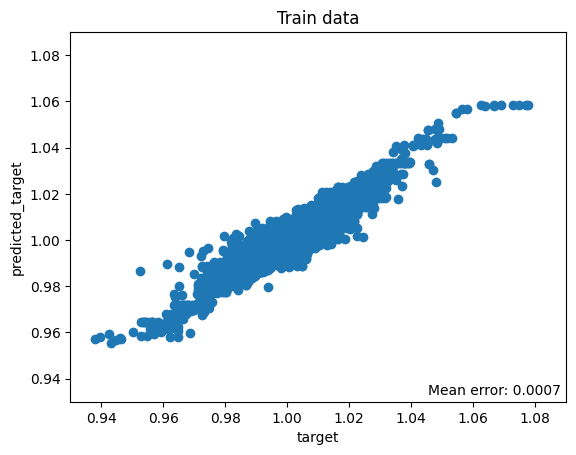

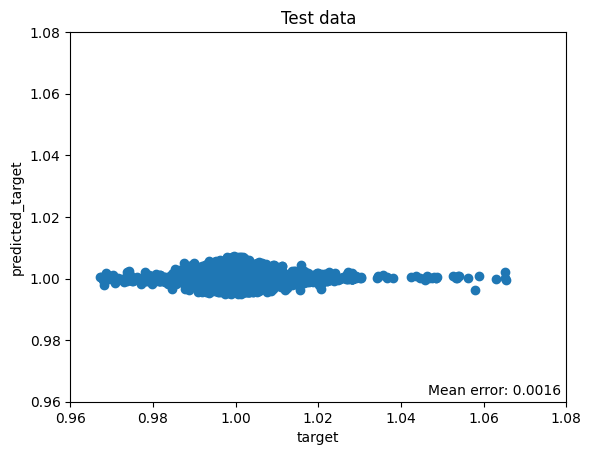

In [45]:
# plot scatter plot, target vs predicted
plt.scatter(y_train['wap_t+60'], x_train['wap_t+60_pred'])
# set axis ranges
plt.xlim(0.93, 1.09)
plt.ylim(0.93, 1.09)
plt.xlabel('target')
plt.ylabel('predicted_target')
plt.title(f'Train data')
# show loss bottom right
plt.text(0.99, 0.01, f"Mean error: {(y_train['wap_t+60'] - x_train['wap_t+60_pred']).abs().mean():.4f}", verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes)
plt.show()

plt.scatter(y_test['wap_t+60'], x_test['wap_t+60_pred'])
plt.xlim(0.96, 1.08)
plt.ylim(0.96, 1.08)
plt.xlabel('target')
plt.ylabel('predicted_target')
plt.title(f'Test data')
# show loss bottom right
plt.text(0.99, 0.01, f"Mean error: {(y_test['wap_t+60'] - x_test['wap_t+60_pred']).abs().mean():.4f}", verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes)
plt.show()

## Predict target based on the stock and index wap predicted

In [ ]:

df_aux = x_train[['date_id', 'seconds_in_bucket', 'wap_t+60_pred', 'weights']]
df_aux = df_aux.rename(columns={'wap_t+60_pred': 'wap'})
df = compute_index(df_aux)
df.rename(columns={'index_wap': 'index_wap_t+60_pred'}, inplace=True)
train_with_pred2 = x_train.merge(df, on=['date_id', 'seconds_in_bucket'], how='left')


df_aux = x_test[['date_id', 'seconds_in_bucket', 'wap_t+60_pred', 'weights']]
df_aux = df_aux.rename(columns={'wap_t+60_pred': 'wap'})
df = compute_index(df_aux)
df.rename(columns={'index_wap': 'index_wap_t+60_pred'}, inplace=True)
test_with_pred2 = x_test.merge(df, on=['date_id', 'seconds_in_bucket'], how='left')


100%|██████████| 2744/2744 [00:00<00:00, 3284.64it/s]


In [ ]:
train_with_pred2["target"] = target_train
df = compute_index(train_with_pred2)
train_with_pred2 = train_with_pred2.merge(df, on=['date_id', 'seconds_in_bucket'], how='left')


test_with_pred2["target"] = target_test
df = compute_index(test_with_pred2)
test_with_pred2 = test_with_pred2.merge(df, on=['date_id', 'seconds_in_bucket'], how='left')
test_with_pred2

100%|██████████| 2744/2744 [00:00<00:00, 2869.27it/s]


,stock_id,imbalance_buy_sell_flag,seconds_in_bucket,imbalance_size,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,date_id,weights,seconds_in_bucket_y,wap_t+60_pred,index_wap_t+60_pred,target,index_wap
0,0,-1,0,7218754.93,1.000062,2.264224e+07,0.999873,10813.75,1.000062,5276.00,1.000000,425,0.004000,60,0.999979,0.999982,1.809597,1.000000
1,1,1,0,238616.53,0.999666,1.585546e+06,0.999223,18022.00,1.000054,1262.59,1.000000,425,0.001000,60,1.000283,0.999982,-3.420114,1.000000
2,2,1,0,4673615.43,0.999974,2.088183e+06,0.999974,895.52,1.000644,22403.00,1.000000,425,0.002000,60,1.000090,0.999982,-0.410080,1.000000
3,3,-1,0,3022158.48,0.999961,1.100225e+08,0.999961,31167.18,1.000063,50186.24,1.000000,425,0.005999,60,0.999980,0.999982,1.610518,1.000000
4,4,-1,0,51388.69,0.999897,2.034596e+07,0.999897,16852.44,1.000200,32888.73,1.000000,425,0.004001,60,0.999990,0.999982,9.109974,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548746,195,-1,480,3202296.36,1.000551,2.773320e+07,1.000551,19822.11,1.000667,60932.20,1.000579,480,0.004001,540,0.999908,1.000049,-1.389980,0.998868
548747,196,-1,480,374092.11,1.000643,9.163117e+06,1.000643,108859.24,1.000900,69567.91,1.000800,480,0.001000,540,1.000506,1.000049,1.319647,0.998868
548748,197,-1,480,1109455.00,0.996164,1.255927e+07,0.996164,42524.00,0.996538,187814.10,0.996233,480,0.004000,540,1.000409,1.000049,-3.259778,0.998868
548749,198,0,480,0.00,0.999210,9.427924e+07,0.999210,366528.00,0.999451,425768.07,0.999322,480,0.005999,540,0.999865,1.000049,-2.020001,0.998868


In [ ]:
def predict_target(df: pd.DataFrame):
    df["predicted_target"] = ((df["wap_t+60_pred"] / df["wap"]) - (df["index_wap_t+60_pred"] / df["index_wap"])) * 10000
    df["error"] = abs(df["predicted_target"] - df["target"])

    logger.info("Mean error", error=(df['predicted_target'] - df['target']).abs().mean())
    return df


predict_target(train_with_pred2)
predict_target(test_with_pred2)

test_with_pred2


2024-04-25 07:57:57 [info     ] Mean error                     error=6.20682409326935
2024-04-25 07:57:57 [info     ] Mean error                     error=13.815998434259983


,stock_id,imbalance_buy_sell_flag,seconds_in_bucket,imbalance_size,reference_price,matched_size,bid_price,bid_size,ask_price,ask_size,wap,date_id,weights,seconds_in_bucket_y,wap_t+60_pred,index_wap_t+60_pred,target,index_wap,predicted_target,error
0,0,-1,0,7218754.93,1.000062,2.264224e+07,0.999873,10813.75,1.000062,5276.00,1.000000,425,0.004000,60,0.999979,0.999982,1.809597,1.000000,-0.029570,1.839167
1,1,1,0,238616.53,0.999666,1.585546e+06,0.999223,18022.00,1.000054,1262.59,1.000000,425,0.001000,60,1.000283,0.999982,-3.420114,1.000000,3.004306,6.424420
2,2,1,0,4673615.43,0.999974,2.088183e+06,0.999974,895.52,1.000644,22403.00,1.000000,425,0.002000,60,1.000090,0.999982,-0.410080,1.000000,1.079076,1.489156
3,3,-1,0,3022158.48,0.999961,1.100225e+08,0.999961,31167.18,1.000063,50186.24,1.000000,425,0.005999,60,0.999980,0.999982,1.610518,1.000000,-0.023610,1.634127
4,4,-1,0,51388.69,0.999897,2.034596e+07,0.999897,16852.44,1.000200,32888.73,1.000000,425,0.004001,60,0.999990,0.999982,9.109974,1.000000,0.074738,9.035236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548746,195,-1,480,3202296.36,1.000551,2.773320e+07,1.000551,19822.11,1.000667,60932.20,1.000579,480,0.004001,540,0.999908,1.000049,-1.389980,0.998868,-18.532155,17.142175
548747,196,-1,480,374092.11,1.000643,9.163117e+06,1.000643,108859.24,1.000900,69567.91,1.000800,480,0.001000,540,1.000506,1.000049,1.319647,0.998868,-14.765936,16.085583
548748,197,-1,480,1109455.00,0.996164,1.255927e+07,0.996164,42524.00,0.996538,187814.10,0.996233,480,0.004000,540,1.000409,1.000049,-3.259778,0.998868,30.095233,33.355011
548749,198,0,480,0.00,0.999210,9.427924e+07,0.999210,366528.00,0.999451,425768.07,0.999322,480,0.005999,540,0.999865,1.000049,-2.020001,0.998868,-6.395680,4.375679
